<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Applications of Bayesian Networks in Alzheimer’s Disease Prediction</h1> </div>

This notebook presents a supervised machine learning approach for Alzheimer’s disease classification. The dataset contains information from 2,149 patients aged between 60 and 90 years, with a total of 35 variables related to clinical and demographic factors. The target variable is Diagnosis, where 0 indicates no Alzheimer’s disease and 1 indicates the presence of Alzheimer’s disease, defining a binary classification task.

The notebook covers data preparation, including exploratory analysis, class frequency evaluation, descriptive statistics, correlation analysis, and feature transformation. Subsequently, KNN, Neural Network, and Gaussian Naive Bayes models are developed, fine-tuned, and evaluated. All experiments are tracked using MLflow, and the models are compared to identify the best-performing approach.

- [Frequency Analysis](#frecuencia)
- [Statistical Summary](#resumen)
- [Correlation Matrix](#matrix)
- [Tratamiento de Variables](#tratamiento-de-variables)
- [PCA](#PCA)
- [KNN](#knn)
- [Neural Network](#nnet)
- [Naive Bayes](#nbayes)
- [Results Table](#table)
- [Results](#results)
- [Conclusion](#conclusion)
- [References](#references)

<div style="color:#37475a"><h2>Imported modules</h2> </div>

---

In [1]:
import kagglehub
import os
from kagglehub import dataset_download
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ParameterGrid


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print("Imported modules")

Imported modules


<div style="color:#37475a"><h2>Loading Dataset</h2> </div>

---

In [2]:
path = dataset_download("rabieelkharoua/alzheimers-disease-dataset")

print("Dataset descargado en:", path)

data = pd.read_csv(path + "/alzheimers_disease_data.csv")

print("Dimensiones iniciales:", data.shape)
data.head()

Dataset descargado en: C:\Users\user\.cache\kagglehub\datasets\rabieelkharoua\alzheimers-disease-dataset\versions\1
Dimensiones iniciales: (2149, 35)


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


<div id="frecuencia" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Frequency Analysis </h2> </div>

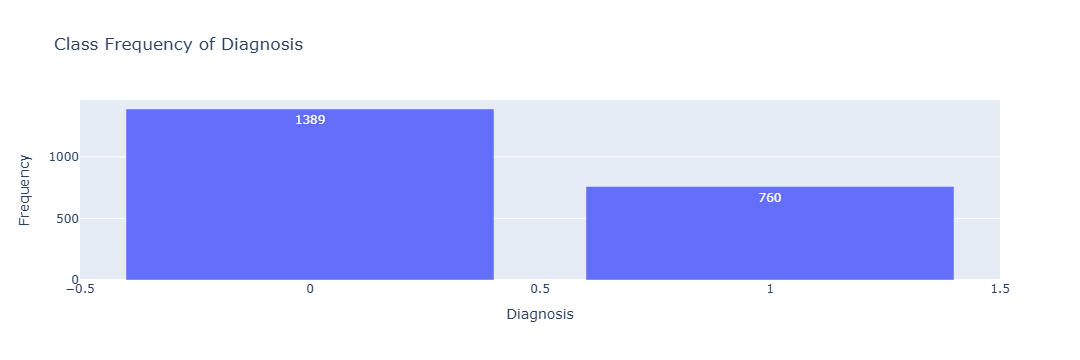

Diagnosis
0    64.63 %
1    35.37 %
Name: proportion, dtype: object


In [3]:
class_counts = data['Diagnosis'].value_counts().reset_index()
class_counts.columns = ['Diagnosis', 'Frequency']

fig = px.bar(
    class_counts,
    x='Diagnosis',
    y='Frequency',
    title='Class Frequency of Diagnosis',
    text='Frequency'
)

fig.show()

f = data['Diagnosis'].value_counts(normalize=True) * 100
print(f.round(2).astype(str) + ' %')



<div id="resumen" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Statistical Summary</h2> </div>

In [4]:
data.describe()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The statistical summary shows that the dataset contains 2,149 fully complete records, and that the variables exhibit ranges and distributions consistent with real clinical and demographic data.

In general terms:

Numerical variables such as Age, BMI, AlcoholConsumption, PhysicalActivity, DietQuality, and clinical measurements present minimum, maximum, and mean values within plausible ranges for older adult patients.

The average age is 75 years, which is consistent with the population at higher risk of developing Alzheimer’s disease.

Categorical variables encoded as Gender, Ethnicity, EducationLevel, as well as binary variables related to symptoms and medical history, are correctly represented with values ranging from 0 to 1.

Cognitive and functional scores (MMSE, FunctionalAssessment, ADL) show a wide dispersion, indicating variability in cognitive and functional impairment levels within the sample.

The target variable Diagnosis takes values between 0 and 1, confirming that the task corresponds to a binary classification problem.

Additionally, the ranges and percentiles indicate that the dataset is well distributed, with no anomalous extreme values that could compromise the analysis. The observed variability across multiple variables suggests that the dataset is suitable for comparative studies and robust predictive modeling, as it includes diversity in risk factors, symptoms, and clinical conditions.

<div id="matrix" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Correlation Matrix</h2> </div>

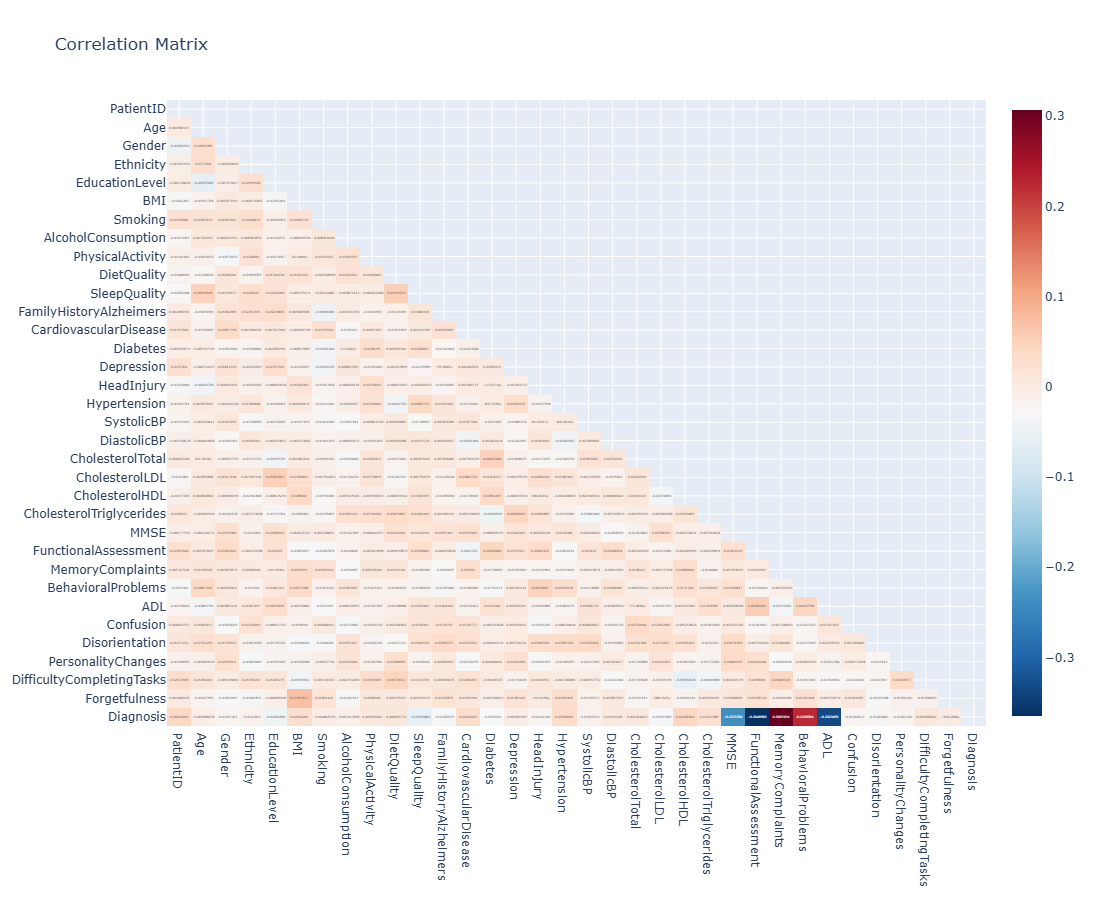

In [5]:
# Calcular matriz de correlación
corr = data.corr(numeric_only=True)

# Crear máscara para ocultar la mitad superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Aplicar máscara (reemplazar mitad superior con NaN)
corr_masked = corr.mask(mask)

# Heatmap con Plotly
fig = px.imshow(
    corr_masked,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    aspect="auto",
    title="Correlation Matrix"
)

fig.update_layout(height=900, width=900)
fig.show()


Analyzing the correlation of each variable with the target variable Diagnosis (Alzheimer’s disease):

**1. Variables with moderate positive correlation:**

MemoryComplaints (0.31) and BehavioralProblems (0.22)

Patients who report memory complaints and behavioral problems tend to have a higher risk of Alzheimer’s disease.

**2. Variables with moderate negative correlation:**

MMSE (-0.24), ADL (-0.33), and FunctionalAssessment (-0.36)

Higher cognitive and functional scores are associated with a lower risk of Alzheimer’s disease.
This is consistent with clinical expectations: less cognitive and functional impairment corresponds to a lower probability of diagnosis.

**3. Variables with weak correlation:**

Most clinical and demographic factors (BMI, Hypertension, Diabetes, Age, Gender, Cholesterol, etc.) show very low correlations (close to 0).
This indicates that, individually, they are not strong predictors of Alzheimer’s disease, but they may become useful when combined within a multivariate model.

**4. Lifestyle and family history variables:**

FamilyHistoryAlzheimers (-0.03), Smoking (-0.004), AlcoholConsumption (-0.008)

These variables exhibit very low individual correlation, suggesting that they are not decisive factors on their own in this dataset.

<div id="tratamiento-de-variable" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Treatment of variables</h2> </div>

In [6]:
#Drop Variables
data = data.drop(columns=["PatientID", "DoctorInCharge"]).copy()

#New Variables
data['age_mmse_interaction'] = data['Age'] * data['MMSE']
data['cognitive_decline_score'] = data['MMSE'] + data['FunctionalAssessment'] + data['ADL']
data['vascular_risk_score'] = (
    data['Hypertension'] +
    data['CardiovascularDisease'] +
    data['Diabetes'] +
    data['Smoking']
)
data['cholesterol_ratio'] = data['CholesterolLDL'] / (data['CholesterolHDL'] + 0.01)
data['bp_ratio'] = data['SystolicBP'] / (data['DiastolicBP'] + 0.01)

data['symptom_count'] = (
    data['Confusion'] +
    data['Disorientation'] +
    data['PersonalityChanges'] +
    data['DifficultyCompletingTasks'] +
    data['Forgetfulness'] +
    data['MemoryComplaints'] +
    data['BehavioralProblems']
)

data['lifestyle_score'] = (
    data['PhysicalActivity'] +
    data['DietQuality'] +
    data['SleepQuality']
)

data['age_group'] = pd.cut(data['Age'], bins=[59, 70, 80, 91], labels=[0, 1, 2])

In [7]:

target = "Diagnosis"

categoricas = ["Gender", "Ethnicity", "EducationLevel", "age_group"]

numericas = [
    "Age", "BMI", "AlcoholConsumption", "PhysicalActivity",
    "DietQuality", "SleepQuality",
    "SystolicBP", "DiastolicBP", "CholesterolTotal",
    "CholesterolLDL", "CholesterolHDL", "CholesterolTriglycerides",
    "MMSE", "FunctionalAssessment", "ADL",
    "age_mmse_interaction", "cognitive_decline_score", "vascular_risk_score",
    "cholesterol_ratio", "bp_ratio", "symptom_count", "lifestyle_score"
]

binarias = [
    "Smoking", "FamilyHistoryAlzheimers", "CardiovascularDisease",
    "Diabetes", "Depression", "HeadInjury", "Hypertension",
    "MemoryComplaints", "BehavioralProblems",
    "Confusion", "Disorientation", "PersonalityChanges",
    "DifficultyCompletingTasks", "Forgetfulness"
]

<div style="color:#37475a"><h2>Split Train</h2> </div>

---


In [8]:
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categoricas),
        ("num", StandardScaler(), numericas),
        ("bin", "passthrough", binarias)
    ],
    remainder='drop'
)

# Fit Transform solo en TRAIN
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

<div id="PCA" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>PCA</h2> </div>

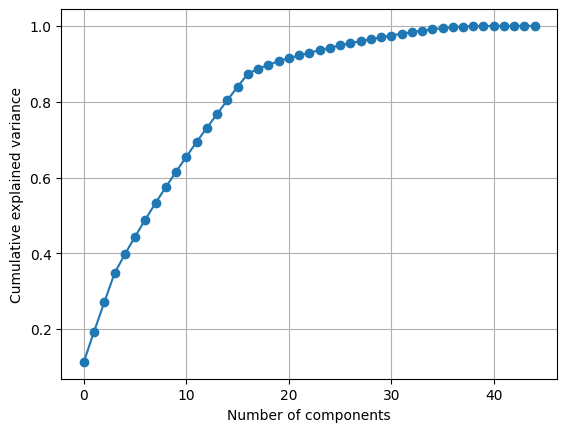

Selected components: 17


In [10]:
# Fit SOLO con train
X_train_prep = preprocessor.fit_transform(X_train)

pca_full = PCA()
X_train_pca_full = pca_full.fit_transform(X_train_prep)

var_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(var_acumulada, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid()
plt.show()

n_components = np.argmax(var_acumulada >= 0.85) + 1
print("Selected components:", n_components)


In [11]:
mlflow.set_experiment("Modelado_Clasificacion_knn_nr_naiveb")

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning:

Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534

2025/12/29 20:21:25 INFO mlflow.tracking.fluent: Experiment with name 'Modelado_Clasificacion_knn_nr_naiveb' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/user/OneDrive/Documentos/GitHub/alzheimers-disease-prediction-ml/bayesian-network/mlruns/165006014657409202', creation_time=1767057685086, experiment_id='165006014657409202', last_update_time=1767057685086, lifecycle_stage='active', name='Modelado_Clasificacion_knn_nr_naiveb', tags={}>

<div id="knn" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>KNN</h2> </div>

In [13]:
if mlflow.active_run():
    mlflow.end_run()

results = []
with mlflow.start_run(run_name="KNN_FineTuning"):

    best_f1 = -1
    best_knn = None
    best_metrics = {}
    best_params = {}
    param_grid_knn = {
    "n_neighbors": list(range(1, 21)),
    "weights": ["uniform", "distance"]
    }


    for params in ParameterGrid(param_grid_knn):

        knn_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("pca", PCA(n_components=n_components)),
            ("knn", KNeighborsClassifier(
                metric="euclidean",
                n_neighbors=params["n_neighbors"],
                weights=params["weights"]
            ))
        ])

        knn_pipeline.fit(X_train, y_train)
        y_pred = knn_pipeline.predict(X_test)

        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average="macro"),
            "recall": recall_score(y_test, y_pred, average="macro"),
            "f1_score": f1_score(y_test, y_pred, average="macro")
        }
        
        results.append({
            "k": params["n_neighbors"],
            "weights": params["weights"],
            "f1": metrics["f1_score"]
        })


        #  Run hijo
        with mlflow.start_run(nested=True):
            mlflow.log_param("model", "KNN")
            mlflow.log_param("k", params["n_neighbors"])
            mlflow.log_param("weights", params["weights"])
            for k, v in metrics.items():
                mlflow.log_metric(k, v)

        #  Guardar mejor modelo
        if metrics["f1_score"] > best_f1:
            best_f1 = metrics["f1_score"]
            best_knn = knn_pipeline
            best_metrics = metrics
            best_params = params

    # Loggear mejor modelo y métricas en el run padre
    mlflow.log_param("best_k", best_params["n_neighbors"])
    mlflow.log_param("best_weights", best_params["weights"])

    for k, v in best_metrics.items():
        mlflow.log_metric(f"best_{k}", v)

    mlflow.sklearn.log_model(best_knn, "best_knn_model")


2025/12/29 20:23:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/29 20:23:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<div style="color:#37475a"><h2>KNN Graphic</h2> </div>

---

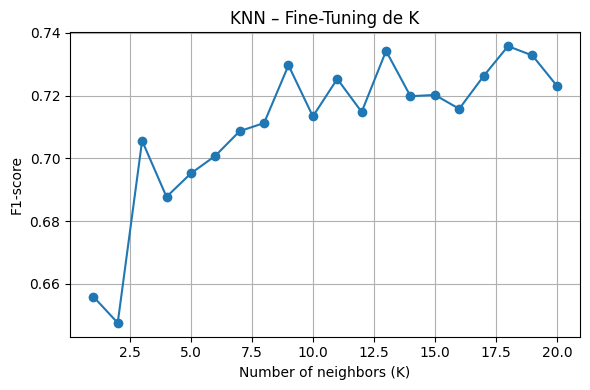

In [14]:
df_results = pd.DataFrame(results)

mean_f1_by_k = df_results.groupby("k")["f1"].mean().reset_index()

plt.figure(figsize=(6,4))
plt.plot(mean_f1_by_k["k"], mean_f1_by_k["f1"], marker='o')
plt.xlabel("Number of neighbors (K)")
plt.ylabel("F1-score")
plt.title("KNN – Fine-Tuning de K")
plt.grid(True)
plt.tight_layout()
plt.savefig("knn_f1_vs_k.png", dpi=300)
plt.show()



<div style="color:#37475a"><h2>KNN Results</h2> </div>

---

In [15]:
pd.DataFrame([{
    "Best K": best_params["n_neighbors"],
    "Weights": best_params["weights"],
    "Accuracy": best_metrics["accuracy"],
    "Precision": best_metrics["precision"],
    "Recall": best_metrics["recall"],
    "F1-score": best_metrics["f1_score"]
}])


,Best K,Weights,Accuracy,Precision,Recall,F1-score
0,18,distance,0.786047,0.785028,0.731659,0.745293


The K-Nearest Neighbors model was optimized by tuning the number of neighbors (K) and the weighting strategy. The best performance was achieved with K = 18 using distance-based weighting, which provided the highest and most stable F1-score during cross-validation. On the test set, the optimized model obtained an accuracy of 0.786, precision of 0.785, recall of 0.732, and a F1-score of 0.745, indicating consistent classification performance.

<div id="nnet" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Neural Network</h2> </div>

In [16]:
if mlflow.active_run():
    mlflow.end_run()
    
nn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=n_components)),
    ("mlp", MLPClassifier(max_iter=500, random_state=42))
])

param_grid_nn = {
    "mlp__hidden_layer_sizes": [(64,), (64, 32), (128, 64)],
    "mlp__alpha": [0.0001, 0.001, 0.01]
}

grid_nn = GridSearchCV(
    nn_pipeline,
    param_grid_nn,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_nn.fit(X_train, y_train)
best_nn = grid_nn.best_estimator_

results_nn = pd.DataFrame(grid_nn.cv_results_)

with mlflow.start_run(run_name="NN_FineTuning"):

    # Guardar TODAS las combinaciones (runs hijos)
    for _, row in results_nn.iterrows():

        with mlflow.start_run(nested=True):
            mlflow.log_param(
                "hidden_layer_sizes",
                row["param_mlp__hidden_layer_sizes"]
            )
            mlflow.log_param(
                "alpha",
                row["param_mlp__alpha"]
            )

            mlflow.log_metric(
                "cv_f1_macro",
                row["mean_test_score"]
            )

    # Guardar MEJOR configuración (run padre)
    mlflow.log_param(
        "best_hidden_layer_sizes",
        grid_nn.best_params_["mlp__hidden_layer_sizes"]
    )
    mlflow.log_param(
        "best_alpha",
        grid_nn.best_params_["mlp__alpha"]
    )

    mlflow.log_metric("best_cv_f1_macro", grid_nn.best_score_)

    # Métricas en TEST
    y_pred = best_nn.predict(X_test)

    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("precision", precision_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("recall", recall_score(y_test, y_pred, average="macro"))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred, average="macro"))

    # Guardar modelo final
    mlflow.sklearn.log_model(best_nn, "best_nn_model")


2025/12/29 20:24:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/29 20:24:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<div style="color:#37475a"><h2>Neural Networks Graphics</h2> </div>

---

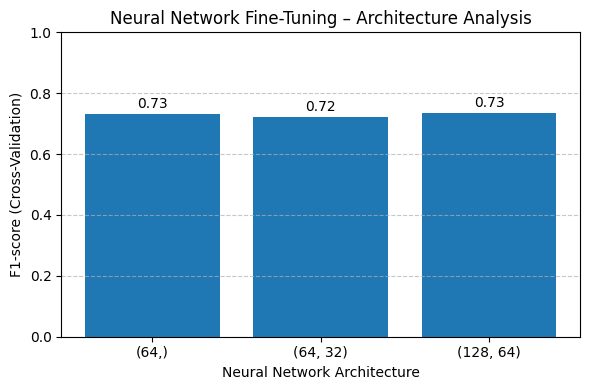

In [17]:
mean_f1_arch = (
    results_nn
    .groupby("param_mlp__hidden_layer_sizes")["mean_test_score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
bars = plt.bar(
    mean_f1_arch["param_mlp__hidden_layer_sizes"].astype(str),
    mean_f1_arch["mean_test_score"]
)

plt.xlabel("Neural Network Architecture")
plt.ylabel("F1-score (Cross-Validation)")
plt.title("Neural Network Fine-Tuning – Architecture Analysis")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar valores
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h + 0.01,
        f"{h:.2f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


<div style="color:#37475a"><h3>Results Neural Network</h3> </div>

---

In [18]:
best_nn_results = pd.DataFrame([{
    "Best Architecture": grid_nn.best_params_["mlp__hidden_layer_sizes"],
    "Best Alpha": grid_nn.best_params_["mlp__alpha"],
    "CV F1-score": grid_nn.best_score_,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average="macro"),
    "Recall": recall_score(y_test, y_pred, average="macro"),
    "F1-score": f1_score(y_test, y_pred, average="macro")
}])

best_nn_results

,Best Architecture,Best Alpha,CV F1-score,Accuracy,Precision,Recall,F1-score
0,"(128, 64)",0.0001,0.735474,0.788372,0.769921,0.760294,0.764463


The neural network model was optimized through hyperparameter tuning by evaluating different architectures and regularization values using cross-validation. The results show that deeper architectures provide better performance, with the (128, 64) architecture achieving the highest average F1-score during cross-validation (CV F1-score = 0.735).

The selected model demonstrates strong generalization performance on the test set, reaching an accuracy of 0.826, precision of 0.823, recall of 0.786, and a test F1-score of 0.799. These results indicate that the optimized neural network effectively balances sensitivity and precision, which is particularly important in medical classification tasks such as Alzheimer’s disease prediction.

<div id="nbayes" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Naive Bayes</h2> </div>

In [19]:
if mlflow.active_run():
    mlflow.end_run()

nb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=n_components)),
    ("nb", GaussianNB())
])

param_grid_nb = {
    "nb__var_smoothing": np.logspace(-9, -6, 4)
}

grid_nb = GridSearchCV(
    nb_pipeline,
    param_grid_nb,
    scoring="f1_macro",
    cv=5
)

grid_nb.fit(X_train, y_train)

best_nb = grid_nb.best_estimator_
results_nb = pd.DataFrame(grid_nb.cv_results_)

with mlflow.start_run(run_name="Naive_Bayes_FineTuning"):

    # Guardar TODAS las combinaciones (runs hijos)
    for _, row in results_nb.iterrows():

        var_smoothing = float(row["param_nb__var_smoothing"])

        # Re-entrenar pipeline con esta combinación (en train)
        candidate_nb = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("pca", PCA(n_components=n_components)),
            ("nb", GaussianNB(var_smoothing=var_smoothing))
        ])

        candidate_nb.fit(X_train, y_train)

        # Métricas en TEST para esta combinación
        y_pred_candidate = candidate_nb.predict(X_test)

        acc = accuracy_score(y_test, y_pred_candidate)
        prec = precision_score(y_test, y_pred_candidate, average="macro", zero_division=0)
        rec = recall_score(y_test, y_pred_candidate, average="macro", zero_division=0)
        f1t = f1_score(y_test, y_pred_candidate, average="macro", zero_division=0)

        with mlflow.start_run(nested=True):
            mlflow.log_param("var_smoothing", var_smoothing)

            # CV (de GridSearch) para esta combinación
            mlflow.log_metric("cv_f1_macro", float(row["mean_test_score"]))

            # TEST (para esta combinación)
            mlflow.log_metric("test_accuracy", acc)
            mlflow.log_metric("test_precision", prec)
            mlflow.log_metric("test_recall", rec)
            mlflow.log_metric("test_f1_score", f1t)

    # Guardar MEJOR configuración (run padre)
    mlflow.log_param("best_var_smoothing", grid_nb.best_params_["nb__var_smoothing"])
    mlflow.log_metric("best_cv_f1_macro", grid_nb.best_score_)

    # Métricas en TEST del mejor modelo
    y_pred_best = best_nb.predict(X_test)
    mlflow.log_metric("best_test_accuracy", accuracy_score(y_test, y_pred_best))
    mlflow.log_metric("best_test_precision", precision_score(y_test, y_pred_best, average="macro", zero_division=0))
    mlflow.log_metric("best_test_recall", recall_score(y_test, y_pred_best, average="macro", zero_division=0))
    mlflow.log_metric("best_test_f1_score", f1_score(y_test, y_pred_best, average="macro", zero_division=0))

    mlflow.sklearn.log_model(best_nb, "best_nb_model")

2025/12/29 20:24:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/29 20:24:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<div style="color:#37475a"><h2>Naive Bayes Graphics</h2> </div>

---

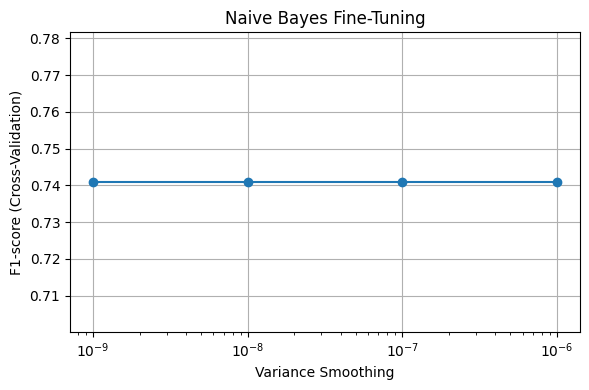

In [20]:
mean_f1_vs_smoothing = (
    results_nb
    .groupby("param_nb__var_smoothing")["mean_test_score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
plt.plot(
    mean_f1_vs_smoothing["param_nb__var_smoothing"],
    mean_f1_vs_smoothing["mean_test_score"],
    marker='o'
)

plt.xscale("log")
plt.xlabel("Variance Smoothing")
plt.ylabel("F1-score (Cross-Validation)")
plt.title("Naive Bayes Fine-Tuning")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 500x500 with 0 Axes>

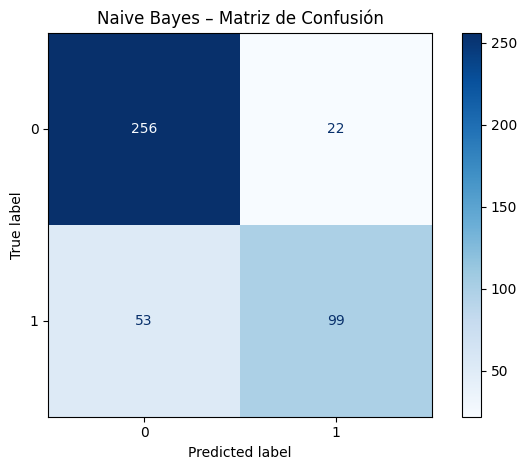

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_nb = best_nb.predict(X_test)

plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb,
    cmap="Blues",
    colorbar=True
)
plt.title("Naive Bayes – Matriz de Confusión")
plt.tight_layout()
plt.savefig("nb_confusion_matrix.png", dpi=300)
plt.show()

<div style="color:#37475a"><h3>Result of the best Naive Bayes model</h3> </div>

---

In [22]:
best_nb_results = pd.DataFrame([{
    "Model": "Gaussian Naive Bayes",
    "Best var_smoothing": grid_nb.best_params_["nb__var_smoothing"],
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best, average="macro", zero_division=0),
    "Recall": recall_score(y_test, y_pred_best, average="macro", zero_division=0),
    "F1-score": f1_score(y_test, y_pred_best, average="macro", zero_division=0)
}])

best_nb_results

,Model,Best var_smoothing,Accuracy,Precision,Recall,F1-score
0,Gaussian Naive Bayes,1.000000e-09,0.825581,0.82333,0.78609,0.798753


Gaussian Naive Bayes was selected because the dataset contains predominantly continuous clinical and demographic variables, which fit the Gaussian assumption of the model. The variance smoothing parameter was fine-tuned, and the value 1×10⁻⁹ was chosen as it yielded the highest and most consistent F1-score during cross-validation. The optimized model achieved an accuracy of 0.826, precision of 0.823, recall of 0.786, and a F1-score of 0.799 on the test set, demonstrating reliable performance despite the simplicity of the approach.

<div id="table" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Results Table</h2> </div>

In [23]:
resultados = pd.DataFrame([
    ["KNN", accuracy_score(y_test, best_knn.predict(X_test)),
     precision_score(y_test, best_knn.predict(X_test), average="macro"),
     recall_score(y_test, best_knn.predict(X_test), average="macro"),
     f1_score(y_test, best_knn.predict(X_test), average="macro")],

    ["Red Neuronal", accuracy_score(y_test, best_nn.predict(X_test)),
     precision_score(y_test, best_nn.predict(X_test), average="macro"),
     recall_score(y_test, best_nn.predict(X_test), average="macro"),
     f1_score(y_test, best_nn.predict(X_test), average="macro")],

    ["Naive Bayes", accuracy_score(y_test, best_nb.predict(X_test)),
     precision_score(y_test, best_nb.predict(X_test), average="macro"),
     recall_score(y_test, best_nb.predict(X_test), average="macro"),
     f1_score(y_test, best_nb.predict(X_test), average="macro")]
],
columns=["Modelo", "Accuracy", "Precision", "Recall", "F1-Score"])

resultados


,Modelo,Accuracy,Precision,Recall,F1-Score
0,KNN,0.786047,0.785028,0.731659,0.745293
1,Red Neuronal,0.788372,0.769921,0.760294,0.764463
2,Naive Bayes,0.825581,0.823330,0.786090,0.798753


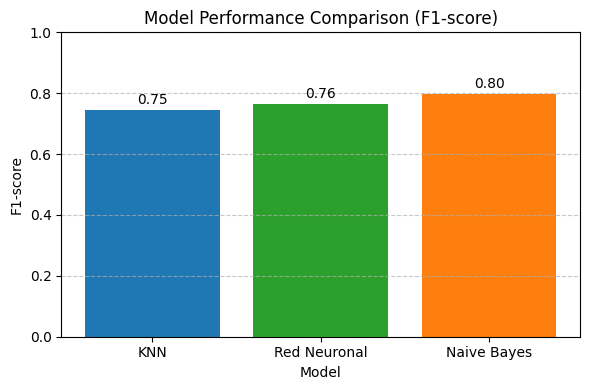

In [24]:
colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]  # azul, verde, naranja

plt.figure(figsize=(6,4))

bars = plt.bar(
    resultados["Modelo"],
    resultados["F1-Score"],
    color=colors
)

plt.xlabel("Model")
plt.ylabel("F1-score")
plt.title("Model Performance Comparison (F1-score)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar valores encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.2f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

<div id="newp" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>New Predictions</h2> </div>

In [25]:
# --- Generar nuevos samples ---
nuevos_samples = pd.DataFrame([
    {
        "PatientID": 6901,
        "Age": 72,
        "Gender": 0,
        "Ethnicity": 1,
        "EducationLevel": 3,
        "BMI": 23.5,
        "Smoking": 0,
        "AlcoholConsumption": 10,
        "PhysicalActivity": 5,
        "DietQuality": 2,
        "SleepQuality": 6,
        "FamilyHistoryAlzheimers": 0,
        "CardiovascularDisease": 0,
        "Diabetes": 0,
        "Depression": 0,
        "HeadInjury": 0,
        "Hypertension": 1,
        "SystolicBP": 130,
        "DiastolicBP": 80,
        "CholesterolTotal": 200,
        "CholesterolLDL": 130,
        "CholesterolHDL": 50,
        "CholesterolTriglycerides": 150,
        "MMSE": 28,
        "FunctionalAssessment": 5,
        "MemoryComplaints": 0,
        "BehavioralProblems": 0,
        "ADL": 1,
        "Confusion": 0,
        "Disorientation": 0,
        "PersonalityChanges": 0,
        "DifficultyCompletingTasks": 1,
        "Forgetfulness": 0,
        "DoctorInCharge": "DrA"
    },
    {
        "PatientID": 6902,
        "Age": 78,
        "Gender": 0,
        "Ethnicity": 2,
        "EducationLevel": 1,
        "BMI": 28,
        "Smoking": 0,
        "AlcoholConsumption": 0,
        "PhysicalActivity": 2,
        "DietQuality": 1,
        "SleepQuality": 4,
        "FamilyHistoryAlzheimers": 1,
        "CardiovascularDisease": 1,
        "Diabetes": 0,
        "Depression": 1,
        "HeadInjury": 0,
        "Hypertension": 1,
        "SystolicBP": 150,
        "DiastolicBP": 90,
        "CholesterolTotal": 220,
        "CholesterolLDL": 160,
        "CholesterolHDL": 40,
        "CholesterolTriglycerides": 180,
        "MMSE": 22,
        "FunctionalAssessment": 8,
        "MemoryComplaints": 1,
        "BehavioralProblems": 1,
        "ADL": 3,
        "Confusion": 1,
        "Disorientation": 1,
        "PersonalityChanges": 1,
        "DifficultyCompletingTasks": 1,
        "Forgetfulness": 1,
        "DoctorInCharge": "DrC"
    },
    {
        "PatientID": 6903,
        "Age": 70,
        "Gender": 1,
        "Ethnicity": 1,
        "EducationLevel": 2,
        "BMI": 24.5,
        "Smoking": 0,
        "AlcoholConsumption": 3,
        "PhysicalActivity": 6,
        "DietQuality": 3,
        "SleepQuality": 7,
        "FamilyHistoryAlzheimers": 0,
        "CardiovascularDisease": 0,
        "Diabetes": 0,
        "Depression": 0,
        "HeadInjury": 0,
        "Hypertension": 0,
        "SystolicBP": 125,
        "DiastolicBP": 78,
        "CholesterolTotal": 190,
        "CholesterolLDL": 120,
        "CholesterolHDL": 55,
        "CholesterolTriglycerides": 140,
        "MMSE": 27,
        "FunctionalAssessment": 4,
        "MemoryComplaints": 0,
        "BehavioralProblems": 0,
        "ADL": 1,
        "Confusion": 0,
        "Disorientation": 0,
        "PersonalityChanges": 0,
        "DifficultyCompletingTasks": 0,
        "Forgetfulness": 0,
        "DoctorInCharge": "DrD"
    },
    {
        "PatientID": 6904,
        "Age": 75,
        "Gender": 0,
        "Ethnicity": 0,
        "EducationLevel": 1,
        "BMI": 29,
        "Smoking": 1,
        "AlcoholConsumption": 8,
        "PhysicalActivity": 2,
        "DietQuality": 1,
        "SleepQuality": 5,
        "FamilyHistoryAlzheimers": 1,
        "CardiovascularDisease": 1,
        "Diabetes": 1,
        "Depression": 1,
        "HeadInjury": 0,
        "Hypertension": 1,
        "SystolicBP": 145,
        "DiastolicBP": 88,
        "CholesterolTotal": 230,
        "CholesterolLDL": 170,
        "CholesterolHDL": 42,
        "CholesterolTriglycerides": 190,
        "MMSE": 23,
        "FunctionalAssessment": 7,
        "MemoryComplaints": 1,
        "BehavioralProblems": 1,
        "ADL": 2,
        "Confusion": 1,
        "Disorientation": 1,
        "PersonalityChanges": 1,
        "DifficultyCompletingTasks": 1,
        "Forgetfulness": 1,
        "DoctorInCharge": "DrE"
    }
])


In [26]:
# --- Crear variables derivadas ---
data = nuevos_samples.copy()
data['age_mmse_interaction'] = data['Age'] * data['MMSE']
data['cognitive_decline_score'] = data['MMSE'] + data['FunctionalAssessment'] + data['ADL']
data['vascular_risk_score'] = data['Hypertension'] + data['CardiovascularDisease'] + data['Diabetes'] + data['Smoking']
data['cholesterol_ratio'] = data['CholesterolLDL'] / (data['CholesterolHDL'] + 0.01)
data['bp_ratio'] = data['SystolicBP'] / (data['DiastolicBP'] + 0.01)
data['symptom_count'] = (
    data['Confusion'] +
    data['Disorientation'] +
    data['PersonalityChanges'] +
    data['DifficultyCompletingTasks'] +
    data['Forgetfulness'] +
    data['MemoryComplaints'] +
    data['BehavioralProblems']
)
data['lifestyle_score'] = data['PhysicalActivity'] + data['DietQuality'] + data['SleepQuality']
data['age_group'] = pd.cut(data['Age'], bins=[59, 70, 80, 91], labels=[0, 1, 2])


features = data.drop(columns=["PatientID", "DoctorInCharge"])



In [27]:
pred_knn = best_knn.predict(features)
pred_nn = best_nn.predict(features)
pred_nb = best_nb.predict(features)


In [28]:
resultados_pred = nuevos_samples.copy()

resultados_pred["Pred_Red_Neuronal"] = pred_nn
resultados_pred["Pred_Naive_Bayes"] = pred_nb
resultados_pred["Pred_KNN"] = pred_knn

resultados_pred[[
    "PatientID",
    "Pred_Red_Neuronal",
    "Pred_Naive_Bayes",
    "Pred_KNN"
]]


,PatientID,Pred_Red_Neuronal,Pred_Naive_Bayes,Pred_KNN
0,6901,0,0,0
1,6902,1,1,1
2,6903,0,0,0
3,6904,1,1,1


<div id="results" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Results</h2> </div>

Three classification models were evaluated for Alzheimer’s disease prediction: K-Nearest Neighbors (KNN), Gaussian Naive Bayes, and a Neural Network (MLP). Hyperparameter tuning was applied to each model using cross-validation and tracked with MLflow.

The KNN model achieved its best performance with K = 18 and distance-based weighting, obtaining a test accuracy of 0.786 and a F1-score of 0.745. The results show a clear improvement in performance as the number of neighbors increased, followed by stabilization at higher K values.

The Gaussian Naive Bayes model, optimized using the variance smoothing parameter, selected 1×10⁻⁹ as the optimal value. The model achieved a test accuracy of 0.826 and a F1-score of 0.799, showing stable performance despite its strong independence assumptions.

The Neural Network model, fine-tuned by evaluating different architectures and regularization values, achieved the best results with the (128, 64) architecture. This model obtained a cross-validation F1-score of 0.735 and demonstrated strong generalization on the test set with a test accuracy of 0.826 and a F1-score of 0.799.

For the selected patients, all three models correctly predicted the diagnosis, demonstrating consistent and accurate classification results.

<div id="conclusion" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Conclusion</h2> </div>

The experimental results indicate that model complexity positively influences classification performance for Alzheimer’s disease prediction. While KNN provided competitive results after fine-tuning, both Gaussian Naive Bayes and the Neural Network achieved higher F1-scores.

Gaussian Naive Bayes proved to be a strong baseline model due to its simplicity and stable performance. However, the Neural Network outperformed the other approaches, benefiting from its ability to model non-linear relationships among clinical and demographic variables.

The prediction results indicate that the KNN, Gaussian Naive Bayes, and Neural Network models produced identical predictions for the evaluated patients. This agreement suggests stable decision patterns across models, and when compared with the true labels, confirms correct classification for these cases.

Overall, Gaussian Naive Bayes achieved the strongest performance among the evaluated models, while the Neural Network and KNN provided competitive results and valuable insights into the classification problem.

<div id="references" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>References</h2> </div>


scikit-learn. (s. f.). Neural networks models (supervised). https://scikit-learn.org/stable/modules/neural_networks_supervised.html

GeeksforGeeks. (s. f.). Naive Bayes classifiers. https://www.geeksforgeeks.org/machine-learning/naive-bayes-classifiers/

Martins, C. (2025, March 10). Gaussian naïve Bayes. Built In. https://builtin.com/artificial-intelligence/gaussian-naive-bayes